# Instructions

The following 2 cells should be run only to post and get the results of a new batch. Since the results of a previous run already exist in mathpix_full_results.json, simply running cell 3 will load and use those results. Avoid uncommenting and rerunning cell 1 and 2 unless there is a good reason since the batch request will incur API costs. 

In [1]:
# from batchRequestHandler import BatchRequestHandler

# handler = BatchRequestHandler()

# # Post Batch
# batch_id = handler.post_batch()
# print("Batch ID:", batch_id)

In [2]:
# import json
# from batchRequestHandler import BatchRequestHandler

# results_json = handler.get_batch_results(batch_id)

In [3]:
# Process the results in a convenient way
import json

with open('./mathpix_full_results.json', 'r') as f:
  results_json = json.load(f)

image_ids = results_json["keys"]
results_data = results_json["results"]

output_json = []
errors_json = []
success_count, error_count = 0, 0
for image_id in image_ids:
    if "error" in results_data[image_id].keys():
        # Track images where errors occured and continue
        errors_json.append(
            {
                "id": image_id,
                "error": results_data[image_id]["error_info"],
                "link": f"https://raw.githubusercontent.com/imzoc/mathpix-annotation/master/mathml-images/images_filtered/{image_id}.png",
            }
        )
        error_count += 1
        continue
    else:
        current_image_result_data = results_data[image_id]["data"]

        mathml_res = []
        latex_res = []
        for row in current_image_result_data:
            if row["type"] == "mathml":
                mathml_res.append(row["value"])
            else:
                latex_res.append(row["value"])

        current_image_consolidated_result_data = {
            "id": image_id,
            "mathml": " ".join(mathml_res),
            "latex": " ".join(latex_res),
            "confidence": float(results_data[image_id]["confidence"])
        }
        output_json.append(current_image_consolidated_result_data)
        success_count += 1


# Save results

# raw results
with open("mathpix_full_results.json", "w") as f:
    json.dump(results_json, f, indent=4)
    print(
        f"Full results have been saved to {f.name}"
    )

with open("mathpix_errors.json", "w") as f:
    json.dump(errors_json, f, indent=4)
    print(
        f"{error_count} images encountered errors. The results have been saved to {f.name}"
    )

# Results for webapp
with open("./mathpix_ocr_tweaker_data.json", "w") as f:
    
    sorted_output_json = sorted(output_json, key=lambda x: x["confidence"])
    json.dump(sorted_output_json,f, indent=4)
    print(
        f"{success_count} images were successfully processed. The results have been saved to {f.name}"
    )


Full results have been saved to mathpix_full_results.json
78 images encountered errors. The results have been saved to mathpix_errors.json
3994 images were successfully processed. The results have been saved to ./mathpix_ocr_tweaker_data.json


Mathpix had 332 results with confidence levels below 50


The following 10 images had the lowest confidence level:

6e74d159-5bf7-4c67-97f2-71a9e286fdea : 0.2% 
Link : https://raw.githubusercontent.com/imzoc/mathpix-annotation/master/mathml-images/images_filtered/6e74d159-5bf7-4c67-97f2-71a9e286fdea.png

31e0d57b-0481-4a4e-a80a-a7e8b4aca730 : 0.33% 
Link : https://raw.githubusercontent.com/imzoc/mathpix-annotation/master/mathml-images/images_filtered/31e0d57b-0481-4a4e-a80a-a7e8b4aca730.png

9b38946a-eab1-4a8a-95aa-4f79b1f451e7 : 0.35% 
Link : https://raw.githubusercontent.com/imzoc/mathpix-annotation/master/mathml-images/images_filtered/9b38946a-eab1-4a8a-95aa-4f79b1f451e7.png

70c2b0a7-852d-4e56-a588-8e1195fb396b : 0.59% 
Link : https://raw.githubusercontent.com/imzoc/mathpix-annotation/master/mathml-images/images_filtered/70c2b0a7-852d-4e56-a588-8e1195fb396b.png

370b5e2a-1c72-4e9d-a45d-fb63634af632 : 0.77% 
Link : https://raw.githubusercontent.com/imzoc/mathpix-annotation/master/ma

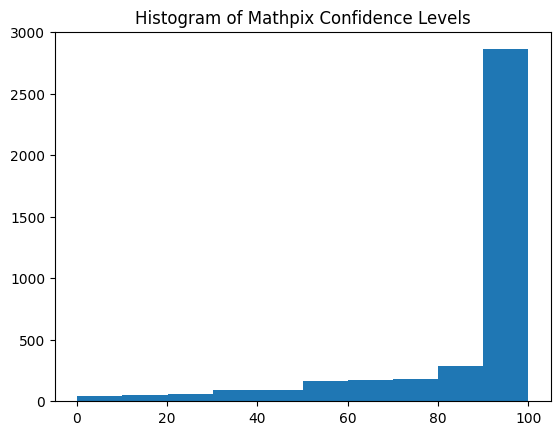

In [4]:
# Basic Confidence Analysis
import numpy as np
import matplotlib.pyplot as plt

confidence_values = np.zeros(success_count)
corresponding_image_ids = [""] * success_count

i = 0
for image_id in image_ids:
    if not "error" in results_data[image_id].keys():
        confidence_values[i] = results_data[image_id]["confidence"]
        corresponding_image_ids[i] = image_id
        i += 1

confidence_values *= 100

# Simultaneously sort the confidence values and their corresponding ids
sort_mask = np.argsort(confidence_values)
confidence_values.sort()
corresponding_image_ids = [corresponding_image_ids[pos] for pos in sort_mask]


plt.title("Histogram of Mathpix Confidence Levels")
plt.hist(confidence_values, bins=10)

confidence_values_below_50 = confidence_values[confidence_values < 50]
print(
    f"Mathpix had {len(confidence_values_below_50)} results with confidence levels below 50\n\n"
)


worst_10_results = [
    (corresponding_image_ids[i], confidence_values[i]) for i in range(1, 10)
]
res = "\n".join(
    [
        f"{image_id} : {np.round(confidence,2)}% \nLink : https://raw.githubusercontent.com/imzoc/mathpix-annotation/master/mathml-images/images_filtered/{image_id}.png\n"
        for image_id, confidence in worst_10_results
    ]
)
print(f"The following 10 images had the lowest confidence level:\n\n{res}\n\n")